## Inferencia del modelo BETO y evaluación en hold-out humano

Objetivo:
Mostrar el funcionamiento del modelo entrenado en escenarios de uso real e incorporar un conjunto de prueba externo construido manualmente.

1️⃣ Cabecera del Notebook 

Celda 1 – imports y device

In [14]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

import pandas as pd
import numpy as np

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

Celda 2 – mapa de etiquetas

In [15]:
id2label = {
    0: "ad_hominem",
    1: "framing_binario",
    2: "logos",
    3: "retorica_vacia",
}
label2id = {v: k for k, v in id2label.items()}
id2label


{0: 'ad_hominem', 1: 'framing_binario', 2: 'logos', 3: 'retorica_vacia'}

2️⃣ Cargar el modelo entrenado

Celda 3 - Carga

In [17]:
MODEL_DIR = "./models/beto_v3_final_fold0"  # la carpeta que acabas de guardar

tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR)
model.to(device)
model.eval()

print("Modelo cargado desde:", MODEL_DIR)


Modelo cargado desde: ./models/beto_v3_final_fold0


3️⃣ Funciones de inferencia

Celda 4

In [18]:
def predict_single(text: str):
    """Devuelve (id_pred, label_pred, probs) para una sola frase."""
    enc = tokenizer(
        text,
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors="pt",
    )
    enc = {k: v.to(device) for k, v in enc.items()}

    with torch.no_grad():
        outputs = model(**enc)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=-1).cpu().numpy()[0]

    pred_id = int(np.argmax(probs))
    pred_label = id2label[pred_id]
    return pred_id, pred_label, probs


def predict_batch(texts):
    """Recibe lista de textos, devuelve (ids_pred, labels_pred, probs)."""
    enc = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors="pt",
    )
    enc = {k: v.to(device) for k, v in enc.items()}

    with torch.no_grad():
        outputs = model(**enc)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=-1).cpu().numpy()

    pred_ids = np.argmax(probs, axis=1)
    pred_labels = [id2label[int(i)] for i in pred_ids]
    return pred_ids, pred_labels, probs


4️⃣ Prueba rápida de demo

Celda 5

In [19]:
ejemplos = [
    "Dice ser honesto, pero encubre a sus amigos",
    "El 60 por ciento de los empleos se perderán si aprobamos esta ley",
    "Ellos quieren destruir el país, nosotros vamos a salvarlo",
    "Promete cambio, pero no explica cómo lo hará",
]

pred_ids, pred_labels, probs = predict_batch(ejemplos)

for txt, lab, p in zip(ejemplos, pred_labels, probs):
    print("TEXTO:", txt)
    print("PRED:", lab, "| probs:", np.round(p, 3))
    print("-" * 80)


TEXTO: Dice ser honesto, pero encubre a sus amigos
PRED: ad_hominem | probs: [0.996 0.002 0.001 0.001]
--------------------------------------------------------------------------------
TEXTO: El 60 por ciento de los empleos se perderán si aprobamos esta ley
PRED: logos | probs: [0.003 0.002 0.992 0.003]
--------------------------------------------------------------------------------
TEXTO: Ellos quieren destruir el país, nosotros vamos a salvarlo
PRED: retorica_vacia | probs: [0.004 0.002 0.002 0.993]
--------------------------------------------------------------------------------
TEXTO: Promete cambio, pero no explica cómo lo hará
PRED: ad_hominem | probs: [0.996 0.002 0.001 0.001]
--------------------------------------------------------------------------------


5️⃣ Construir o cargar el hold-out humano
Opción A: lo construyes aquí mismo

Celda 6

(pon tus propias frases; aquí va solo un mini ejemplo)

In [6]:
data_holdout = [
    ("Dice ser honesto, pero encubre a sus amigos", "ad_hominem"),
    ("Quieren destruir el país, nosotros vamos a rescatarlo", "framing_binario"),
    ("El 40% de los jóvenes perdió su empleo el último año", "logos"),
    ("Promete cambio, pero no explica cómo lo hará", "retorica_vacia"),
    # agrega aquí muchas más frases creadas por ti...
]

df_holdout = pd.DataFrame(data_holdout, columns=["text", "label_name"])
df_holdout["label"] = df_holdout["label_name"].map(label2id)

HOLDOUT_PATH = "../data/holdout_humano.csv"
df_holdout.to_csv(HOLDOUT_PATH, index=False, encoding="utf-8")
df_holdout.head()


,text,label_name,label
0,"Dice ser honesto, pero encubre a sus amigos",ad_hominem,0
1,"Quieren destruir el país, nosotros vamos a res...",framing_binario,1
2,El 40% de los jóvenes perdió su empleo el últi...,logos,2
3,"Promete cambio, pero no explica cómo lo hará",retorica_vacia,3


Opción B: ya tienes el CSV

Entonces solo:

In [7]:
HOLDOUT_PATH = "../data/holdout_humano.csv"
df_holdout = pd.read_csv(HOLDOUT_PATH)
df_holdout.head()


,text,label_name,label
0,"Dice ser honesto, pero encubre a sus amigos",ad_hominem,0
1,"Quieren destruir el país, nosotros vamos a res...",framing_binario,1
2,El 40% de los jóvenes perdió su empleo el últi...,logos,2
3,"Promete cambio, pero no explica cómo lo hará",retorica_vacia,3


6️⃣ Evaluar BETO en el hold-out

Celda 7

In [8]:
texts = df_holdout["text"].tolist()
true_ids = df_holdout["label"].tolist()

pred_ids, pred_labels, probs = predict_batch(texts)

df_holdout["pred_id"] = pred_ids
df_holdout["pred_label"] = [id2label[i] for i in pred_ids]

print("Tamaño hold-out:", len(df_holdout))
df_holdout.head()


Tamaño hold-out: 4


,text,label_name,label,pred_id,pred_label
0,"Dice ser honesto, pero encubre a sus amigos",ad_hominem,0,0,ad_hominem
1,"Quieren destruir el país, nosotros vamos a res...",framing_binario,1,3,retorica_vacia
2,El 40% de los jóvenes perdió su empleo el últi...,logos,2,2,logos
3,"Promete cambio, pero no explica cómo lo hará",retorica_vacia,3,0,ad_hominem


Celda 8 – métricas

In [9]:
target_names = [id2label[i] for i in sorted(id2label)]
print(classification_report(true_ids, pred_ids, target_names=target_names))


                 precision    recall  f1-score   support

     ad_hominem       0.50      1.00      0.67         1
framing_binario       0.00      0.00      0.00         1
          logos       1.00      1.00      1.00         1
 retorica_vacia       0.00      0.00      0.00         1

       accuracy                           0.50         4
      macro avg       0.38      0.50      0.42         4
   weighted avg       0.38      0.50      0.42         4



d:\_ JCAM 2010-2028\_3_MASTERAI_UNI\Ciclo4\Tesis 2 Proyecto\ProyectoClasificador\ClasificadorsemanticoBETO\beto_gpu\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\_ JCAM 2010-2028\_3_MASTERAI_UNI\Ciclo4\Tesis 2 Proyecto\ProyectoClasificador\ClasificadorsemanticoBETO\beto_gpu\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\_ JCAM 2010-2028\_3_MASTERAI_UNI\Ciclo4\Tesis 2 Proyecto\ProyectoClasificador\ClasificadorsemanticoBETO\beto_gpu\lib\site-packages\sklearn\metrics\_classification.py:1

Celda 9 – matriz de confusión del hold-out

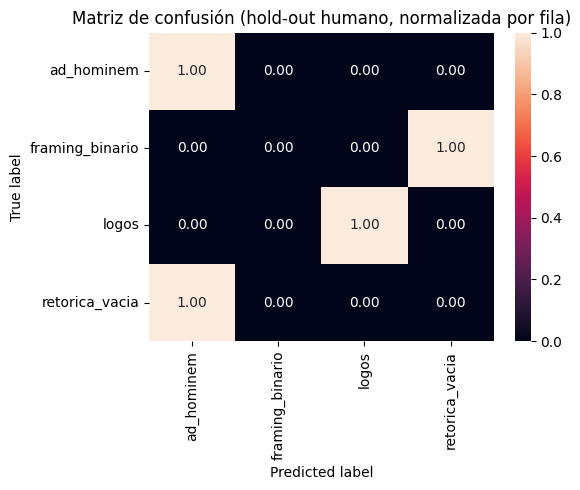

In [10]:
cm = confusion_matrix(true_ids, pred_ids, labels=sorted(id2label))
cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    xticklabels=target_names,
    yticklabels=target_names,
    cbar=True,
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Matriz de confusión (hold-out humano, normalizada por fila)")
plt.tight_layout()
plt.show()


Celda 10 – errores típicos (para discusión)

In [13]:
errores = df_holdout[df_holdout["label"] != df_holdout["pred_id"]].copy()
print("Nº de errores en hold-out:", len(errores))
errores[["text", "label_name" if "label_name" in errores.columns else "label", "pred_label"]].head(20)


Nº de errores en hold-out: 2


,text,label_name,pred_label
1,"Quieren destruir el país, nosotros vamos a res...",framing_binario,retorica_vacia
3,"Promete cambio, pero no explica cómo lo hará",retorica_vacia,ad_hominem
